In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import os

In [50]:
def lorentz(init, length, T, p=10., r=28., b=8/3):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(3)
        next_pos[0] = prev_pos[0] + interval * (-p*(prev_pos[0] - prev_pos[1]))
        next_pos[1] = prev_pos[1] + interval * (-prev_pos[0]*prev_pos[2] + r*prev_pos[0] - prev_pos[1])
        next_pos[2] = prev_pos[2] + interval * (prev_pos[0]*prev_pos[1] - b*prev_pos[2])
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos

def VanDelPol(init, length, T, eps=0.3):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(2)
        next_pos[0] = prev_pos[0] + interval * (prev_pos[1])
        next_pos[1] = prev_pos[1] + interval * (-prev_pos[0] + eps*prev_pos[1]*(1 - prev_pos[0]*prev_pos[0]))
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos


def Nonlinear(init, length, T):
    interval = T / length
    pos = []
    prev_pos = init
    pos.append(prev_pos)
    for i in range(length):
        next_pos = torch.zeros(1)
        # next_pos[0] = prev_pos[0] + interval * (-prev_pos[0] * prev_pos[0] * prev_pos[0])
        next_pos[0] = prev_pos[0] + interval * (-prev_pos[0] * prev_pos[0] + prev_pos[0])
        pos.append(next_pos)
        prev_pos = next_pos
    pos = torch.stack(pos)
    return pos

In [51]:
# init = torch.tensor([1.,1.,1.])
# length = 1000
# T = 10
# pos = lorentz(init, length, T)

# init = torch.tensor([1.,10.])
# length = 10000
# T = 100
# pos = VanDelPol(init, length, T, eps=5.)

init = torch.tensor([1.])
length = 10000
T = 100
pos = Nonlinear(init, length, T)

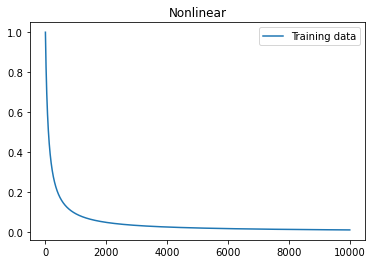

In [52]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# plt.rcParams["font.size"] = 10
# plt.plot(pos[:,0], pos[:,1], pos[:,2] , label="Training data")
# plt.title("Lorentz Curves")
# plt.legend()
# fig.savefig("Lorentz"+".png")

# fig = plt.figure()
# ax = fig.add_subplot()
# plt.rcParams["font.size"] = 10
# plt.plot(pos[:,0], pos[:,1], label="Training data")
# plt.title("Van Del Pol")
# plt.legend()
# fig.savefig("Lorentz"+".png")

fig = plt.figure()
ax = fig.add_subplot()
plt.rcParams["font.size"] = 10
plt.plot(pos[:,0], label="Training data")
plt.title("Nonlinear")
plt.legend()

In [22]:
pos[:,0] == pos[:,0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

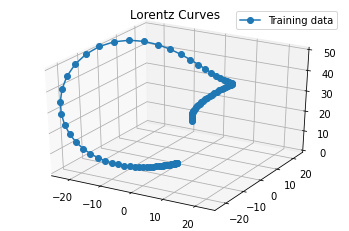

In [38]:
DMM_dics = torch.load(os.path.join("saveData", "20211215_21_18", "DMM_dic"))
pos = DMM_dics["mini_batch"][1]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)
ax.set_zlim(0,50)
plt.rcParams["font.size"] = 10
# plt.scatter(pos[:,0], pos[:,2], pos[:,1])
plt.plot(pos[:,0], pos[:,1], pos[:,2] , "o-", label="Training data")
plt.title("Lorentz Curves")
plt.legend()
fig.savefig("Lorentz2"+".png")

In [13]:
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`
    """

    def __init__(self, input_dim, z_dim, emission_dim, use_cuda=False):
        super().__init__()
        self.input_dim = input_dim
        self.use_cuda = use_cuda
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution `p(x_t|z_t)`
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        if self.input_dim == 1:
            x = self.lin_hidden_to_input(h2)
        else:
            ps = torch.sigmoid(self.lin_hidden_to_input(h2))

            #Reparameterization Trick
            if self.use_cuda: 
                eps = torch.rand(self.input_dim).cuda()
            else : eps = torch.rand(self.input_dim)
            # assert len(emission_probs_t) == 88
            appxm = torch.log(eps + 1e-20) - torch.log(1-eps + 1e-20) + torch.log(ps + 1e-20) - torch.log(1-ps + 1e-20)
            # appxm = torch.log(eps) - torch.log(1-eps) + torch.log(x) - torch.log(1-x)
            x = torch.sigmoid(appxm)
        return x

class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in the reference for comparison.
    """

    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, x_{t:T})`, which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on `x_{t:T}` is
    through the hidden state of the RNN (see the PyTorch module `rnn` below)
    """

    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Encoder(nn.Module):
    def __init__(self, input_dim=88, z_dim=100,rnn_dim=60, num_layers=1, rnn_dropout_rate=0.1,num_iafs=0, iaf_dim=50, N_z0 = 10, use_cuda=False, rnn_check=False):
        super().__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.combiner = Combiner(z_dim, rnn_dim)
        # dropout just takes effect on inner layers of rnn
        rnn_dropout_rate = 0. if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim, nonlinearity='relu',
                          batch_first=True, bidirectional=False, num_layers=num_layers,
                          dropout=rnn_dropout_rate)

        # if we're using normalizing flows, instantiate those too
        # self.iafs = [affine_autoregressive(z_dim, hidden_dims=[iaf_dim]) for _ in range(num_iafs)]
        # self.iafs_modules = nn.ModuleList(self.iafs)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))

        # randnでやっても失敗した。やっぱりいけた。学習率が問題？
        # onesでやってみる 訓練データ1つならOK
        # self.z_0 = nn.Parameter(torch.randn(z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(z_dim))
        
        # self.z_0 = nn.Parameter(torch.randn(N_z0, z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(N_z0, z_dim))

        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.randn(1, 1, rnn_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all PyTorch (sub)modules
        if use_cuda:
            self.cuda()

        self.rnn_check = rnn_check

    def forward(self, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths, annealing_factor=1.0):

        # this is the number of time steps we need to process in the mini-batch
        T_max = mini_batch.size(1)

        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, mini_batch.size(0), self.rnn.hidden_size).contiguous()
        # if any(torch.isnan(h_0_contig.reshape(-1))):
        #     for param in self.rnn.parameters():
        #         print(param)
        #     assert False
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        # if True:
        #     if any(torch.isnan(rnn_output.data.reshape(-1))):
        #         assert False

        # reverse the time-ordering in the hidden state and un-pack it
        rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)

        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        # z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        # z_prev = self.z_q_0

        # if any(torch.isnan(z_prev.reshape(-1))):
        #     print("z_prev")

        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
            # if args.clip != None:
            #     z_scale = torch.clamp(z_scale, min = args.clip)
            # Reparameterization Trick
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps

            # the latent sampled at this time step will be conditioned upon
            # in the next time step so keep track of it
            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)

class Prior(nn.Module):
    def __init__(self, z_dim=100, transition_dim=200,  N_z0 = 10, use_cuda=False):
        super().__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.trans = GatedTransition(z_dim, transition_dim)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))

        # self.z_0 = nn.Parameter(torch.randn(z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(z_dim))
        
        # self.z_0 = nn.Parameter(torch.randn(N_z0, z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(N_z0, z_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all PyTorch (sub)modules

    def forward(self, length, N_generate):

        # this is the number of time steps we need to process in the mini-batch
        T_max = length

        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(N_generate, self.z_q_0.size(0))
        # z_prev = self.z_q_0.expand(N_generate, self.z_q_0.size(0))
        # z_prev = self.z_q_0

        # if any(torch.isnan(z_prev.reshape(-1))):
        #     print("z_prev")

        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.trans(z_prev)
            # if args.clip != None:
            #     z_scale = torch.clamp(z_scale, min = args.clip)

            # Reparameterization Trick
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps

            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)